In [1]:
pip install pyclustering

# Mounting Google Drive Locally

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Machine Learning Assignments/Assignment3/2019224_HW3

/content/drive/My Drive/Machine Learning Assignments/Assignment3/2019224_HW3


# Import Modules

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import math

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from pyclustering.cluster.kmedians import kmedians
from sklearn.decomposition import PCA

# Import Dataset

In [5]:
df_population = pd.read_csv('datasets/population.csv')
df_more_than_50k = pd.read_csv('datasets/more_than_50k.csv')
df_data_description = pd.read_csv('datasets/Dataset Description.csv',index_col=0)

Classifying numerical and categorical columns using dataset descriptions

In [6]:
df_data_description.head()

,Distict Values,Column,Type
Column Code,,,
AAGE,91,age,numerical
ACLSWKR,9,class of worker,categorical
ADTIND,52,industry code,categorical
ADTOCC,47,occupation code,categorical
AHGA,17,education,categorical


In [7]:
categorical_cols = df_data_description[df_data_description.Type=='categorical'].index.tolist()
numerical_cols = df_data_description[df_data_description.Type=='numerical'].index.tolist()

# 1 Preprocessing

### 1.1 Replacing Missing Data : ? With NaN

In [8]:
df_population.replace(' ?',np.NaN,inplace=True)
df_more_than_50k.replace(' ?',np.NaN,inplace=True)

### 1.2 Removing Columns Based on Percentage of Missing Values

Columns With Missing Values

In [9]:
cols_with_missing_values_population = df_population.columns[df_population.isnull().any()]
cols_with_missing_values_50k = df_more_than_50k.columns[df_more_than_50k.isnull().any()]

Percentage of Missing Values for population dataset

In [10]:
df_population[cols_with_missing_values_population].isnull().sum() * 100 / len(df_population)

GRINST       0.354846
MIGMTR1     49.967172
MIGMTR3     49.967172
MIGMTR4     49.967172
MIGSUN      49.967172
PEFNTVTY     3.364524
PEMNTVTY     3.066814
PENATVTY     1.700556
dtype: float64

Percentage of missing values for more than 50k dataset

In [11]:
df_more_than_50k[cols_with_missing_values_50k].isnull().sum()*100/len(df_more_than_50k)

GRINST       0.391061
MIGMTR1     53.240223
MIGMTR3     53.240223
MIGMTR4     53.240223
MIGSUN      53.240223
PEFNTVTY     4.525140
PEMNTVTY     3.743017
PENATVTY     2.597765
dtype: float64

Columns more than 40% missing values and are dropped

In [12]:
cols_to_drop = ['MIGMTR1','MIGMTR3','MIGMTR4','MIGSUN']
df_population.drop(columns=cols_to_drop,inplace=True)
df_more_than_50k.drop(columns=cols_to_drop,inplace=True)
for col in cols_to_drop:
  categorical_cols.remove(col)

# 2 Feature Analysis

### 2.1 Histograms of Numerical Features

In [13]:
def histogram_numerical(data):
  data[numerical_cols].hist(figsize=(10,10),bins=10)
  plt.tight_layout()
  plt.show()

For population dataset - The columns AHRSPAY, CAPGAIN, CAPLOSS, DIVVAL have more than 70% values in their one of the columns. Such columns should be dropped.

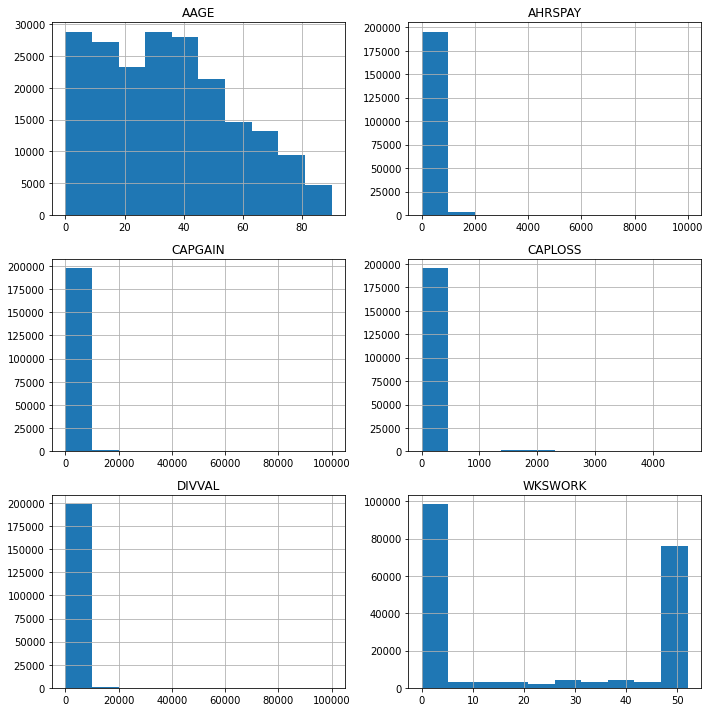

In [14]:
histogram_numerical(df_population)

For more than 50k dataset - All columns here except the AAGE column have more than 70% of their values in one of the columns. However, since the operations performed on this dataset should align with the those performed on population dataset, the same columns are dropped. 

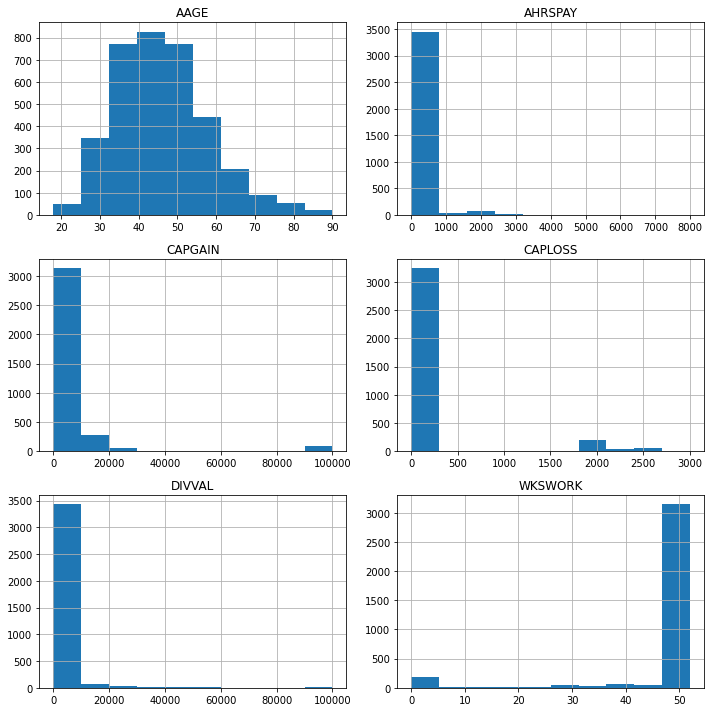

In [15]:
histogram_numerical(df_more_than_50k)

### 2.1 Histograms of Categorical Features

In [16]:
def histogram_categorical(data):
  """
  For categorical features value counts are used to plot the histogram.
  """
  for idx,col in enumerate(categorical_cols):
    plt.subplot(12,3,idx+1)
    data[col].value_counts().plot.bar(figsize=(20,100))
    plt.title(col)

  plt.suptitle("Histograms of Categorical Features")
  plt.tight_layout()
  plt.show()

For population dataset - The categorical columns - ['AHSCOL',
 'ARACE',
 'AREORGN',
 'AUNMEM',
 'AUNTYPE',
 'GRINREG',
 'GRINST',
 'PARENT',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'SEOTR',
 'VETQVA',
 'VETYN'] have more than 70% values in one the columns. Such columns are dropped.

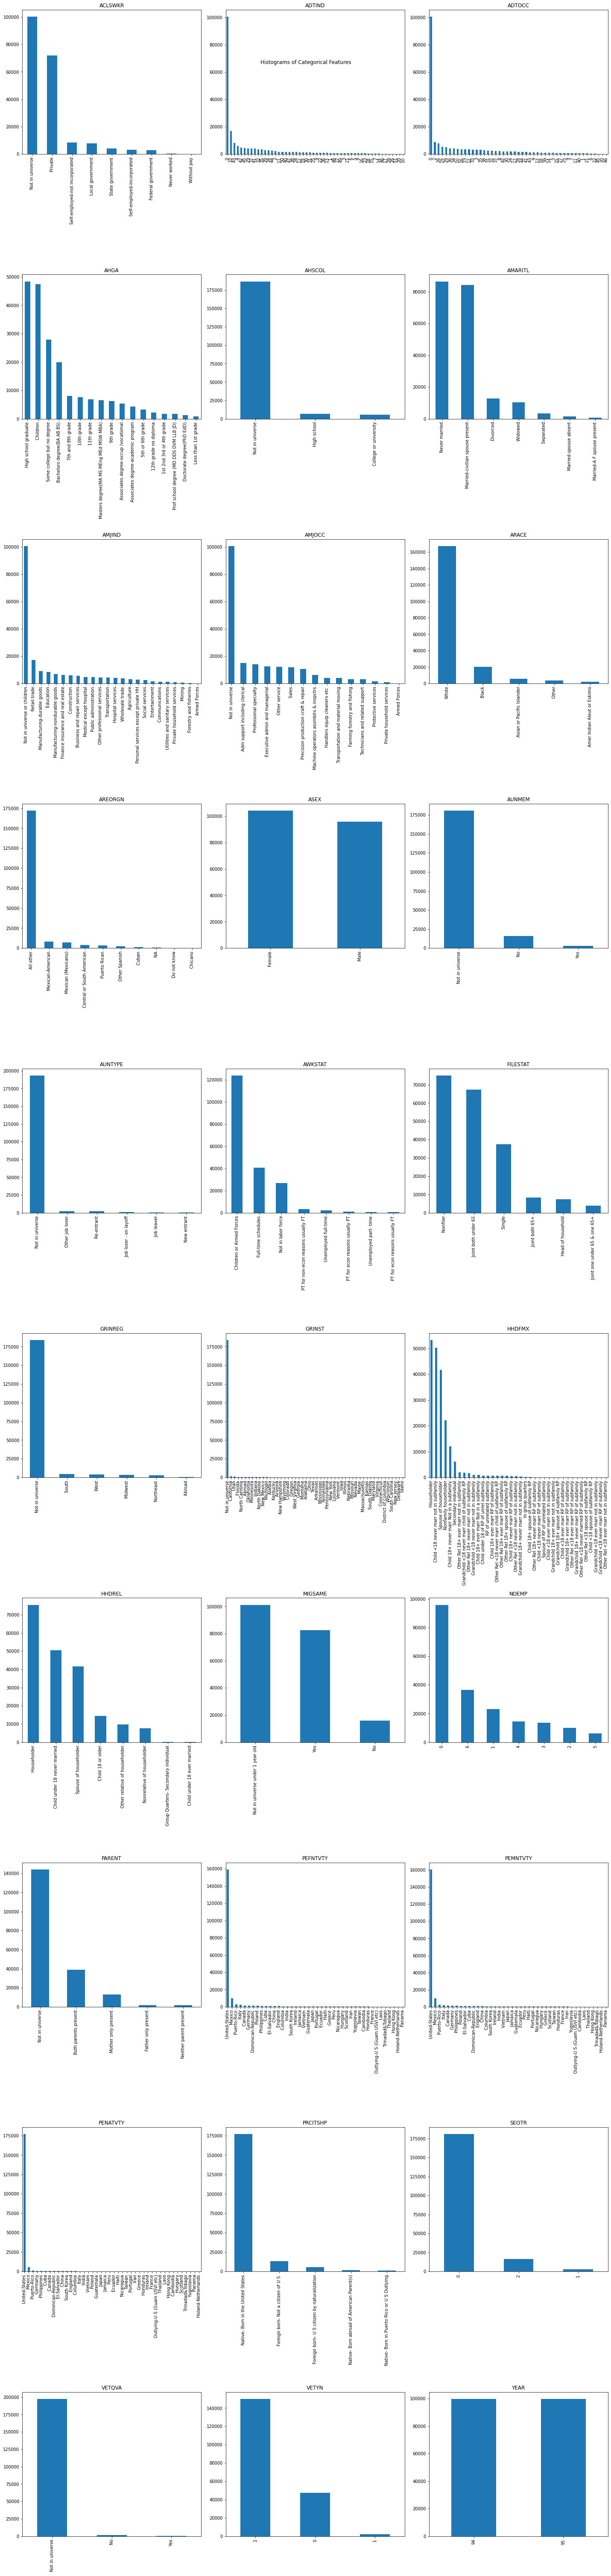

In [17]:
histogram_categorical(df_population)

For population more than 50k dataset - the columns ['AHSCOL',
 'AMARITL',
 'ARACE',
 'AREORGN',
 'ASEX',
 'AUNMEM',
 'AUNTYPE',
 'FILESTAT',
 'GRINREG',
 'GRINST',
 'HHDREL',
 'PARENT',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'SEOTR',
 'VETQVA',
 'VETYN'] have more than 70% values in one on the columns. Since the operations performed on this dataset should align with the population dataset, the same columns will be dropped.

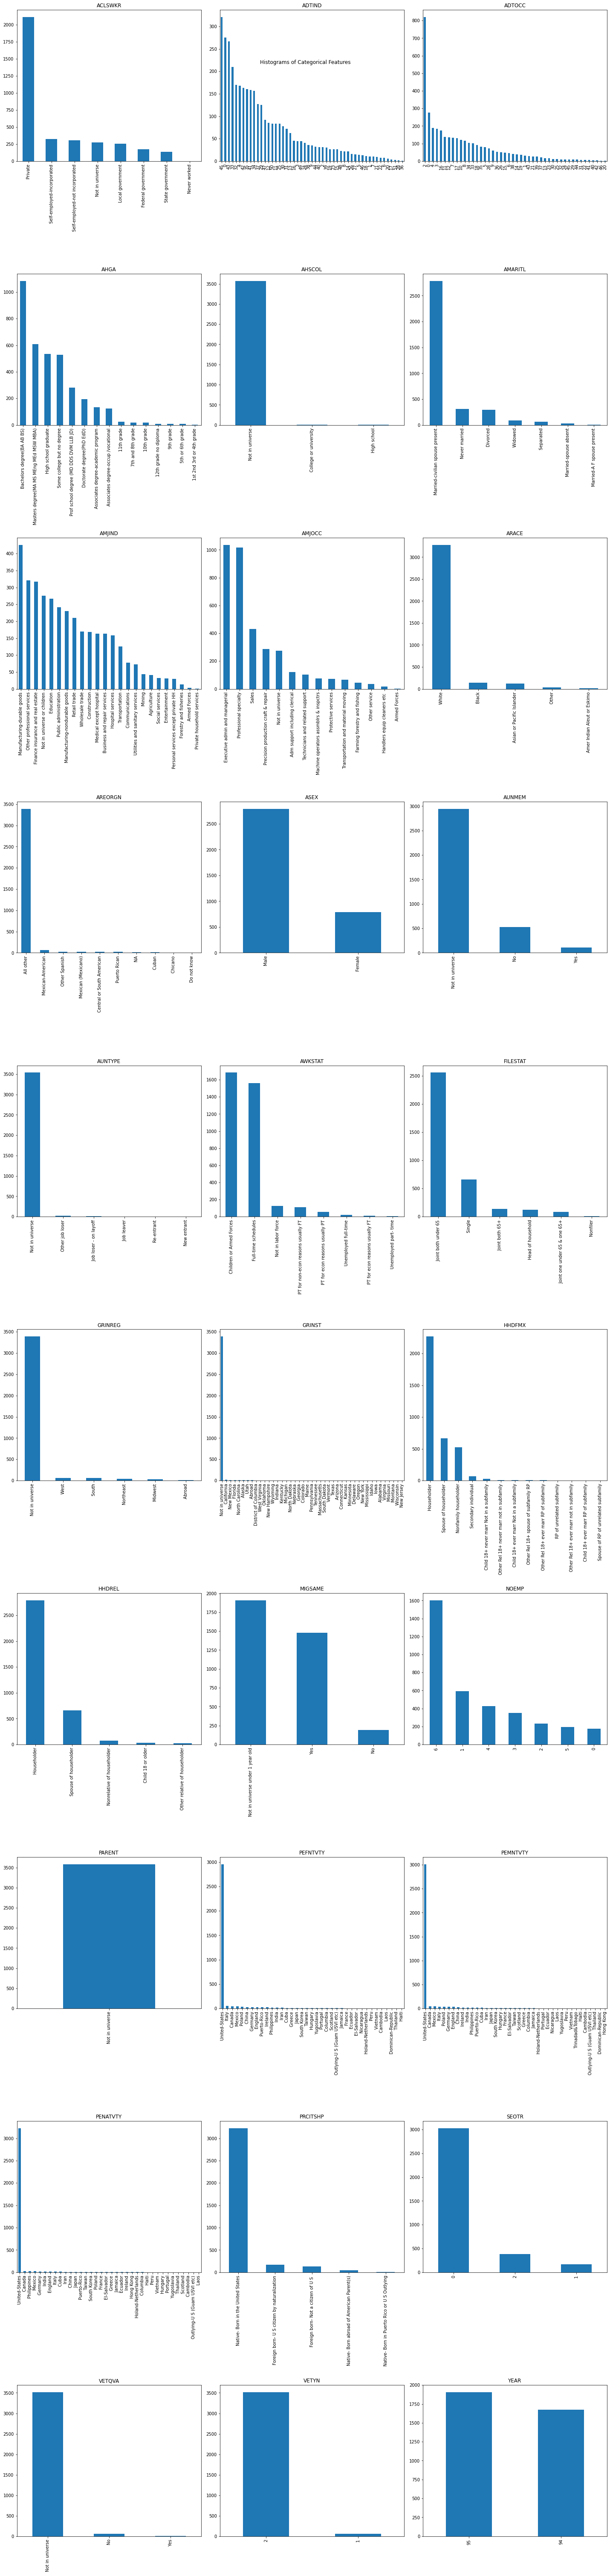

In [18]:
histogram_categorical(df_more_than_50k)

### 2.2 Dropping Features

In [19]:
threshold = 70

From the Histograms a threshold value of 70% was decided. Columns with >= 70% values in one column were dropped

In [20]:
print("Percentage of values in majority column (Categorical):")

cols_to_drop_numerical = []

for col in numerical_cols:
  df_cut = pd.cut(df_population[col],10)
  percentage = df_cut.value_counts().max()/len(df_cut)*100
  print(col,math.trunc(percentage),"%")
  if percentage>=threshold:
    cols_to_drop_numerical.append(col)

Percentage of values in majority column (Categorical):
AAGE 15 %
AHRSPAY 97 %
CAPGAIN 99 %
CAPLOSS 98 %
DIVVAL 99 %
WKSWORK 49 %


In [21]:
print("Categorical columns dropped")
cols_to_drop_numerical

Categorical columns dropped


['AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL']

In [22]:
print("Percentage of values in majority column (Numerical):")

cols_to_drop_categorical = []

for col in categorical_cols:
  percentage = df_population[col].value_counts().max()/len(df_population)*100
  print(col,math.trunc(percentage),"%")
  if percentage>=threshold:
    cols_to_drop_categorical.append(col)

Percentage of values in majority column (Numerical):
ACLSWKR 50 %
ADTIND 50 %
ADTOCC 50 %
AHGA 24 %
AHSCOL 93 %
AMARITL 43 %
AMJIND 50 %
AMJOCC 50 %
ARACE 83 %
AREORGN 86 %
ASEX 52 %
AUNMEM 90 %
AUNTYPE 96 %
AWKSTAT 62 %
FILESTAT 37 %
GRINREG 92 %
GRINST 92 %
HHDFMX 26 %
HHDREL 37 %
MIGSAME 50 %
NOEMP 48 %
PARENT 72 %
PEFNTVTY 79 %
PEMNTVTY 80 %
PENATVTY 88 %
PRCITSHP 88 %
SEOTR 90 %
VETQVA 99 %
VETYN 75 %
YEAR 50 %


In [23]:
print("Numerical columns dropped")
cols_to_drop_categorical

Numerical columns dropped


['AHSCOL',
 'ARACE',
 'AREORGN',
 'AUNMEM',
 'AUNTYPE',
 'GRINREG',
 'GRINST',
 'PARENT',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'SEOTR',
 'VETQVA',
 'VETYN']

In [24]:
#removing the dropped columns from the columns lists and dropping columns

for col in cols_to_drop_numerical:
  numerical_cols.remove(col)

for col in cols_to_drop_categorical:
  categorical_cols.remove(col)

cols_to_drop = cols_to_drop_numerical+cols_to_drop_categorical

# same colummns were dropped from the 2 datasets since the operations should align
df_population.drop(columns=cols_to_drop,inplace=True)
df_more_than_50k.drop(columns=cols_to_drop,inplace=True)

# 3 Imputation, Bucketization, One Hot Encoding

### 3.1 Replace Missing Values With Mode

In [25]:
cols_with_missing_values = df_population.columns[df_population.isnull().any()]

In [26]:
modes = {}
for col in cols_with_missing_values:
  modes[col] = df_population[col].mode()[0]
  df_population[col].fillna(modes[col],inplace=True)
  df_more_than_50k[col].fillna(modes[col],inplace=True)

### 3.2 Bucketize Numerical Features

In [27]:
for col in numerical_cols:
  df_population[col],bins = pd.cut(df_population[col],10,retbins=True)
  df_more_than_50k[col] = pd.cut(df_more_than_50k[col],bins) #same bins used as population dataset

### 3.3 One Hot Encode

In [28]:
encoder = OneHotEncoder()
arr_population = encoder.fit_transform(df_population).toarray()
arr_50k = encoder.transform(df_more_than_50k).toarray()

df = pd.DataFrame(arr_population)
df_50k = pd.DataFrame(arr_50k)

In [29]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
df_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### 3.4 PCA on Population Dataset

A) Cumulative Variance vs Number of Components

In [31]:
pca = PCA(n_components = 100, random_state=0)
df_pca = pca.fit_transform(df)
print("The cumulative variance percentage is ",np.cumsum(pca.explained_variance_ratio_)*100," for 100 PC")

The cumulative variance percentage is  [25.05284228 35.02692008 42.23567354 47.85862962 52.13299546 54.83017926
 56.75412739 58.46837204 59.97317391 61.40625429 62.8094204  64.12431577
 65.35647231 66.50686016 67.62561006 68.66051646 69.66734289 70.59468326
 71.45760312 72.2956833  73.1288233  73.92200212 74.70159102 75.43502659
 76.13267738 76.82039761 77.47744002 78.10621765 78.70441724 79.29946593
 79.87527014 80.43385314 80.98382077 81.49281856 81.98028107 82.4633092
 82.93246776 83.39506863 83.84841375 84.2928282  84.71506268 85.13290518
 85.53973701 85.93719466 86.32058678 86.6860738  87.04537426 87.40051542
 87.74268072 88.07182955 88.39102605 88.70072972 89.00802293 89.28794566
 89.56622754 89.83271017 90.08680758 90.3350221  90.57707601 90.81284578
 91.04266907 91.26885855 91.4867865  91.69693026 91.90460937 92.10837247
 92.3076684  92.49817214 92.68328645 92.86681778 93.04692711 93.22499462
 93.39973714 93.57222459 93.73776548 93.89814281 94.05582885 94.20712058
 94.35555354 

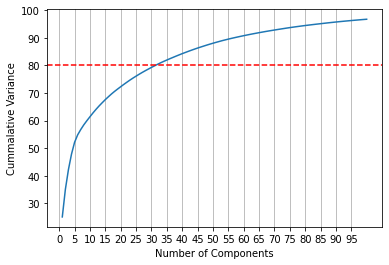

In [32]:
#plotting cumulative variance vs number of components

fig, ax = plt.subplots()
x = np.arange(pca.n_components_) + 1
y = np.cumsum(pca.explained_variance_ratio_)*100
plt.plot(x,y)
plt.axhline(y=80, color='r', linestyle='--')
plt.xticks(np.arange(0, 100, step=5))
plt.xlabel("Number of Components")
plt.ylabel("Cummalative Variance")
ax.grid(axis='x')
plt.show()

B) Value 32 was chosen by taking the threshold as above 80

C) Fitting PCA again with chosen value

In [33]:
pca = PCA(n_components=32,random_state=0)
df_pca = pca.fit_transform(df)
df = pd.DataFrame(df_pca)

### 3.5 PCA On 50K Dataset

In [34]:
df_50k = pd.DataFrame(pca.transform(df_50k))

In [35]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,-1.349271,1.382897,0.902056,0.082159,1.126653,0.094776,-0.497823,-0.380272,-0.114754,-0.210475,0.177395,0.026895,-0.049624,0.244882,-0.138613,0.013969,-0.217560,0.645822,-0.506845,-0.134353,-0.011005,0.389257,-0.042951,-0.140939,0.170038,0.263983,-0.097348,-0.301067,-0.188418,-0.340833,0.327621,0.057780
1,1.411583,-0.932778,-0.747985,1.086353,0.178747,-0.298829,0.217400,-0.072323,0.796413,-0.829496,-0.921851,0.150839,0.368795,-0.378851,1.274847,0.844804,-0.446595,0.601909,-0.051374,0.183600,-0.544152,-0.037311,-0.214736,0.706326,-0.417048,0.820869,0.111351,1.321708,-0.124371,0.393033,-0.515566,-0.244921
2,-1.606649,1.351446,0.156011,-0.397534,0.877716,0.471720,-0.106073,0.882745,0.075695,-0.717509,0.656695,-0.341145,-0.011092,0.092556,-0.109451,-0.326773,-0.057813,0.354726,-0.423468,-0.102271,0.038536,0.291750,0.116345,-0.170302,-0.323407,-0.062992,-0.001756,0.486361,-0.270292,-0.120108,0.056619,0.328081
3,-2.339228,-0.976997,-0.188318,-0.628658,-0.234244,-0.636767,-0.065346,-0.083285,-0.133358,-0.041860,-0.235455,0.214460,-0.047263,-0.122991,-0.303539,-0.129016,0.015746,-0.157659,-0.005820,0.126612,-0.070218,-0.065996,-0.001709,0.048979,-0.016972,-0.038357,0.018943,0.068533,0.148726,0.239201,0.234639,0.237114
4,-2.292607,-0.970999,-0.182179,-0.635050,-0.121538,-0.485280,-0.146083,0.242468,0.346775,-0.111456,0.631011,-0.303484,-0.077694,-0.222895,-0.001794,-0.078710,0.078567,-0.048715,-0.012859,-0.053894,0.142569,-0.200161,-0.156318,0.114482,-0.031624,0.027732,-0.005155,-0.071241,0.064327,0.025710,-0.085506,-0.022516


In [36]:
df_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1.969663,1.048060,-0.121488,1.170621,-0.650674,-0.280567,-0.272481,-0.473187,0.067239,-0.358060,0.130953,0.224262,-0.024097,-0.226404,-0.149737,-0.367773,0.562736,0.276049,-0.082928,-0.540773,0.474549,-0.765433,0.621622,0.050576,0.415154,0.704914,0.470931,0.260404,-0.000909,-0.180847,0.005376,0.330912
1,1.769038,-1.286252,0.615527,-0.141593,-0.979153,0.878613,-0.230125,-0.823522,-0.032655,0.013611,0.148041,-0.104592,-0.820556,0.275632,0.140428,-0.234959,-0.303709,-0.329174,-0.065163,-0.447618,0.054532,0.274685,0.076039,-0.263763,-0.124596,-0.020256,0.135429,-0.267562,-0.405844,0.375323,-0.051355,-0.083802
2,1.971417,-1.304825,-0.055565,0.944126,-0.440536,-0.268726,-0.418431,-0.291659,-0.922240,0.008157,0.669273,0.098083,-0.289007,-0.571354,-0.042647,0.546008,0.532308,0.218361,0.103222,0.170554,0.205590,0.800085,0.042619,0.002658,0.212710,-0.364105,-0.179569,-0.244981,-0.105113,-0.075436,0.091929,0.193044
3,1.497064,1.029256,-1.682558,-0.503174,0.234856,0.954972,-0.228079,0.309255,0.305462,0.481754,-0.363850,0.245614,-0.103699,0.222019,-0.320760,-0.594102,0.490596,0.551351,0.020228,-0.579332,0.197449,-0.496663,0.322395,0.292249,0.520606,0.550546,-0.404568,-0.356351,-0.124067,-0.121179,0.481821,-0.006055
4,2.056289,1.085899,0.686973,-1.199081,-0.614010,0.014507,0.594034,0.250854,-0.591571,0.299438,0.185460,-0.091679,-0.082686,0.428321,-0.219077,-0.390625,0.553031,0.140700,0.042542,0.651148,0.122494,-0.252568,-0.660236,-0.189297,-0.339941,0.115211,0.089953,-0.017347,0.371924,0.320655,-0.179408,-0.389288


# 4 Clustering on population dataset

### 4.1 K-Median Clustering With Varying Values of K

In [37]:
def kmedians_clustering_varying_k_values(data,folder):
  """
  apply k-medians clustering for a range of k values and plot graphs for average within cluster distance
  and number of clusters
  """
  distance_cluster = []
  distance_point = []

  print("Average Within Cluster Distances\n")

  for k in range(1,25):
    filename = folder+'/clusters k='+str(k)+'.pickle'
    if os.path.exists(filename):

      with open(filename,'rb') as file:
        kmedians_ = pickle.load(file)

    else:

      #chosing initial medians as random k rows
      arr = np.random.choice(len(data),k,replace=False)
      initial_medians = data.loc[arr]

      #fit kmedians
      kmedians_ = kmedians(data,initial_medians)
      kmedians_.process()

      with open(filename,'wb+') as file:
        pickle.dump(kmedians_,file)

    #get the distance
    dist_within_a_cluster = np.around(kmedians_.get_total_wce()/k,decimals=2)
    dist_for_a_point = np.around(kmedians_.get_total_wce()/len(data),decimals=2)
    print("k =",k,", for a cluster",dist_within_a_cluster," for a point",dist_for_a_point)
    distance_cluster.append(dist_within_a_cluster)
    distance_point.append(dist_for_a_point)

  print()
  plt.plot(np.arange(1,25),distance_cluster)
  plt.xlabel("Number of Clusters")
  plt.ylabel("Average Within Cluster Distance for a cluster")
  plt.show()

  print()
  plt.plot(np.arange(1,25),distance_point)
  plt.xlabel("Number of Clusters")
  plt.ylabel("Average Within Cluster Distance for a point")
  plt.show()

Average Within Cluster Distances

k = 1 , for a cluster 3682845.22  for a point 18.46
k = 2 , for a cluster 1220046.4  for a point 12.23
k = 3 , for a cluster 754359.25  for a point 11.34
k = 4 , for a cluster 440098.52  for a point 8.82
k = 5 , for a cluster 392208.41  for a point 9.83
k = 6 , for a cluster 304780.11  for a point 9.17
k = 7 , for a cluster 283316.92  for a point 9.94
k = 8 , for a cluster 220035.61  for a point 8.82
k = 9 , for a cluster 182447.01  for a point 8.23
k = 10 , for a cluster 153785.15  for a point 7.71
k = 11 , for a cluster 154955.93  for a point 8.54
k = 12 , for a cluster 133445.49  for a point 8.03
k = 13 , for a cluster 95493.25  for a point 6.22
k = 14 , for a cluster 99211.57  for a point 6.96
k = 15 , for a cluster 84140.77  for a point 6.33
k = 16 , for a cluster 84013.67  for a point 6.74
k = 17 , for a cluster 82630.65  for a point 7.04
k = 18 , for a cluster 70548.59  for a point 6.36
k = 19 , for a cluster 72141.79  for a point 6.87
k = 20 , 

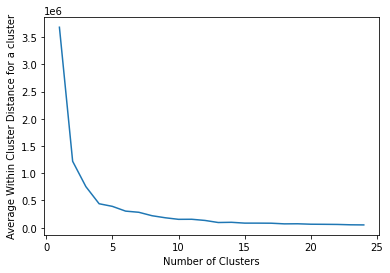

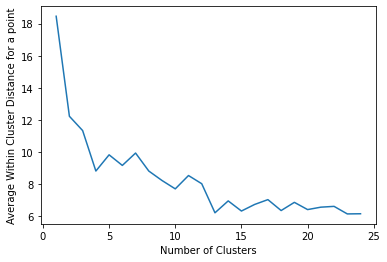

In [38]:
kmedians_clustering_varying_k_values(df,'Weights/clusters')

### 4.2 

The value chosen for k is 23 as the graph starts becoming constant around this value and the elbow is observed. The value 4 could also be chosen from the elbow curve but it does not lie in the provided range [10,24].

In [39]:
chosen_k = 13

###4.3 K-Median Clustering With Best Value Chosen

In [40]:
with open('Weights/clusters/clusters k='+str(chosen_k)+'.pickle','rb') as file:
  kmedians_best = pickle.load(file)

# Approach 1: Clustering using Population Dataset Clusters

## 5 Clustering on more than 50k Dataset

In [41]:
def euclidean_distance(point_start, point_end):
  """
  calculates and returns the euclidean distance between two points start and end
  """
  dist = 0
  for i in range(len(point_start)):
    dist = dist + math.pow(point_start[i]-point_end[i],2)
  return math.pow(dist,0.5)

In [42]:
def wce(data,y_pred,model):
  """
  returns the sum of euclidean distances of each point to its closest cluster median
  """
  medians = model.get_medians()
  wce_ = 0
  for index,row in data.iterrows():
    label = y_pred[index]
    wce_+=euclidean_distance(row,medians[label])
  return wce_

### Varying Values of K

Average Within Cluster Distances

k = 1 , for a cluster 15722.86  for a point 4.39
k = 2 , for a cluster 6595.48  for a point 3.68
k = 3 , for a cluster 4008.29  for a point 3.36
k = 4 , for a cluster 2733.0  for a point 3.05
k = 5 , for a cluster 2088.81  for a point 2.92
k = 6 , for a cluster 1919.18  for a point 3.22
k = 7 , for a cluster 1680.78  for a point 3.29
k = 8 , for a cluster 1289.27  for a point 2.88
k = 9 , for a cluster 1132.31  for a point 2.85
k = 10 , for a cluster 1035.79  for a point 2.89
k = 11 , for a cluster 863.17  for a point 2.65
k = 12 , for a cluster 814.2  for a point 2.73
k = 13 , for a cluster 658.71  for a point 2.39
k = 14 , for a cluster 668.05  for a point 2.61
k = 15 , for a cluster 651.84  for a point 2.73
k = 16 , for a cluster 603.04  for a point 2.7
k = 17 , for a cluster 542.01  for a point 2.57
k = 18 , for a cluster 502.38  for a point 2.53
k = 19 , for a cluster 501.92  for a point 2.66
k = 20 , for a cluster 488.18  for a point 2.73
k = 21 

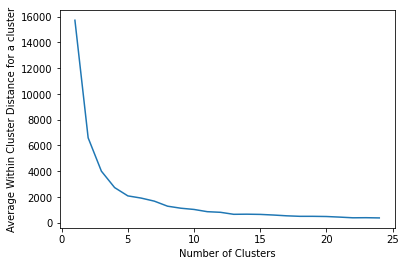

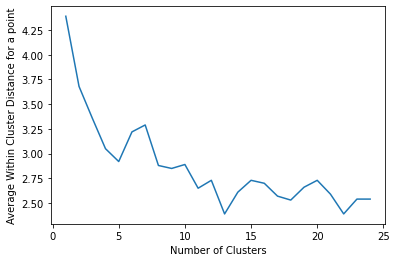

In [43]:
distance_cluster = []
distance_point = []

print("Average Within Cluster Distances\n")

for k in range(1,25):
  with open('Weights/clusters/clusters k='+str(k)+'.pickle','rb') as file:
    kmedians_ = pickle.load(file)
  
  #predict clusters
  y_pred = kmedians_.predict(df_50k.values.tolist())

  #calculate the distance
  dist = wce(df_50k,y_pred,kmedians_)

  dist_within_a_cluster = np.around(dist/k,decimals=2)
  dist_for_a_point = np.around(dist/len(df_50k),decimals=2)
  print("k =",k,", for a cluster",dist_within_a_cluster," for a point",dist_for_a_point)
  distance_cluster.append(dist_within_a_cluster)
  distance_point.append(dist_for_a_point)

#plot graphs
print()
plt.plot(np.arange(1,25),distance_cluster)
plt.xlabel("Number of Clusters")
plt.ylabel("Average Within Cluster Distance for a cluster")
plt.show()

print()
plt.plot(np.arange(1,25),distance_point)
plt.xlabel("Number of Clusters")
plt.ylabel("Average Within Cluster Distance for a point")
plt.show()

### Clustering with the best chosen value from part 4

In [44]:
y = kmedians_best.predict(df_50k.values.tolist())

##6 Comparing More Than 50k With Population Data

### 6.1 Comparing Proportion of Data in each cluster for more than 50k data to the proportion of data in each cluster for general population

In [45]:
def compare_proportions(len_of_clusters_population,len_of_clusters_50k):
  """
  takes the lengths of the clusters as arguments and returns the proportions
  """

  print("Cluster Lengths for Population Dataset",len_of_clusters_population)
  print("Cluster Length for More Than 50k Dataset",len_of_clusters_50k)

  len_50k = len(df_50k)
  len_population = len(df)

  proportion_population = np.array([len/len_population for len in len_of_clusters_population])
  proportion_50k = np.array([len/len_50k for len in len_of_clusters_50k])

  print("\nProportion of data in each cluster for population dataset",proportion_population)
  print("Proportion of data in each cluster for More than 50k dataset",proportion_50k)

  return proportion_population,proportion_50k

In [46]:
len_of_clusters_population = np.array([len(cluster) for cluster in kmedians_best.get_clusters()])
len_of_clusters_50k =  np.bincount(y)

prop_pop, prop_50k = compare_proportions(len_of_clusters_population,len_of_clusters_50k)

Cluster Lengths for Population Dataset [11962 28667 10784 14269 21924 14432 17782 15280 29172  4222  8258 10683
 12088]
Cluster Length for More Than 50k Dataset [ 225    6  348   33 1218  212  118  876    0   60   37  100  347]

Proportion of data in each cluster for population dataset [0.05995299 0.14367767 0.05404891 0.07151556 0.10988207 0.07233251
 0.08912256 0.07658265 0.14620871 0.02116047 0.04138871 0.0535427
 0.06058449]
Proportion of data in each cluster for More than 50k dataset [0.06284916 0.00167598 0.0972067  0.00921788 0.34022346 0.05921788
 0.03296089 0.24469274 0.         0.01675978 0.0103352  0.02793296
 0.09692737]


### 6.2 Over-represented Clusters

In [47]:
def overrepresented_clusters(dataset_main_prop,dataset_sec_prop):
  """
  takes 2 lists of proportions,, and for each index calculates the representation percentages
  for each cluster index using the formula differences_of_proportions*100.

  A value greater than 0 denotes that the cluster is overrerpresented as compared to the second dataset
  """

  for i in range(len(dataset_main_prop)):
    rep_percentage = (dataset_main_prop[i] - dataset_sec_prop[i])*100
    if(rep_percentage>0):
      print("Cluster",i," is overrepresented by",rep_percentage,"%")

Clusters overrepresented in population data as compared to more than 50k data

In [48]:
overrepresented_clusters(prop_pop,prop_50k)

Cluster 1  is overrepresented by 14.200169359229022 %
Cluster 3  is overrepresented by 6.22976875266505 %
Cluster 5  is overrepresented by 1.311463594863694 %
Cluster 6  is overrepresented by 5.616166344440989 %
Cluster 8  is overrepresented by 14.620870776802676 %
Cluster 9  is overrepresented by 0.44006911791886205 %
Cluster 10  is overrepresented by 3.1053516547580506 %
Cluster 11  is overrepresented by 2.5609738444066195 %


Clusters overrepresented in more than 50k population data as compared to population data

In [49]:
overrepresented_clusters(prop_50k,prop_pop)

Cluster 0  is overrepresented by 0.2896174135088726 %
Cluster 2  is overrepresented by 4.3157797268272535 %
Cluster 4  is overrepresented by 23.03413949532204 %
Cluster 7  is overrepresented by 16.811008781082545 %
Cluster 12  is overrepresented by 3.6342880283442485 %


### 6.3 and 6.4

In [50]:
# datasets before applying pca

df_pop_before_pca = pd.DataFrame(arr_population,columns = encoder.get_feature_names())
df_50k_before_pca = pd.DataFrame(arr_50k,columns = encoder.get_feature_names())

In [51]:
def people_in_overrepresented_clusters(cluster_index,model):
  """
  returns the kinds of people that are a part of a cluster that is overrepresented
  """

  #get the median of the cluster index using the model from the arguments
  median = model.get_medians()[cluster_index]
  #inverse transform the median using pca to map to orignal features
  inverse_transformed_median = pca.inverse_transform(median)
  #round the values to 0 and 1 as was there in the orignal one hot encoded array
  inverse_transformed_median = [round(a) for a in inverse_transformed_median]

  #using values of first principal component to sort the features 
  feature_select = pd.DataFrame(pca.components_,columns=df_50k_before_pca.columns).T[0]
  #get feature names after one hot encoding
  col_names = encoder.get_feature_names()
  #get actual feature names using dataset description
  actual_feature_names = df_data_description.loc[df_population.columns]['Column']

  #stores the feature name, its value as key and PC1 value as the value
  features = {}

  for i in range(len(inverse_transformed_median)):
    if inverse_transformed_median[i]==1:
      index = int(col_names[i][1:col_names[i].index("_")])
      feature_name = actual_feature_names.iloc[index]
      features[feature_name+": "+col_names[i]] = feature_select[col_names[i]]

  #sort by PC1 values in descending order
  return pd.DataFrame.from_dict(features,orient='index').sort_values(ascending=False,by=0).head(3)

**For cluster 4 -overrepresented in 50k dataset**

This cluster represents people who have worked for 46.8-52 weeks in a year, have tax filer status as joint both under 65 and married civilians wiht spouse.

In [52]:
people_in_overrepresented_clusters(4,kmedians_best)

,0
"weeks worked in year: x15_(46.8, 52.0]",0.224429
tax filer status: x10_ Joint both under 65,0.167290
marital status: x5_ Married-civilian spouse present,0.153650


**For cluster 8 overrepresented in population dataset**

This cluster represents males, with data collected in year 1995 and not in the universe under 1 year old. 

In [53]:
people_in_overrepresented_clusters(8,kmedians_best)

,0
sex: x8_ Male,0.024591
data collected in the year: x16_95,0.015503
live in this house 1 year ago: x13_ Not in universe under 1 year old,0.009623


# Approach 2: Clustering Seperately

## 5 Clustering on more than 50k Dataset

### Varying Values of K

Average Within Cluster Distances

k = 1 , for a cluster 40086.74  for a point 11.2
k = 2 , for a cluster 13674.06  for a point 7.64
k = 3 , for a cluster 9639.13  for a point 8.08
k = 4 , for a cluster 7358.21  for a point 8.22
k = 5 , for a cluster 7286.61  for a point 10.18
k = 6 , for a cluster 5080.02  for a point 8.51
k = 7 , for a cluster 4120.27  for a point 8.06
k = 8 , for a cluster 3045.68  for a point 6.81
k = 9 , for a cluster 2795.72  for a point 7.03
k = 10 , for a cluster 2844.59  for a point 7.95
k = 11 , for a cluster 2507.04  for a point 7.7
k = 12 , for a cluster 2013.77  for a point 6.75
k = 13 , for a cluster 1713.09  for a point 6.22
k = 14 , for a cluster 1648.66  for a point 6.45
k = 15 , for a cluster 1636.63  for a point 6.86
k = 16 , for a cluster 1439.64  for a point 6.43
k = 17 , for a cluster 1477.25  for a point 7.01
k = 18 , for a cluster 1182.85  for a point 5.95
k = 19 , for a cluster 1169.22  for a point 6.21
k = 20 , for a cluster 1083.57  for a poin

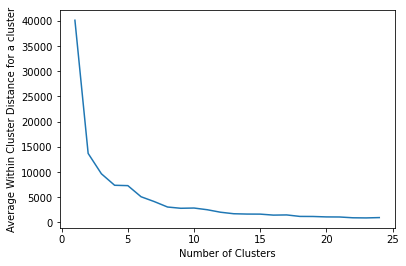

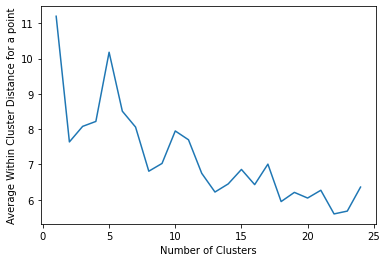

In [54]:
kmedians_clustering_varying_k_values(df_50k,'Weights/clusters_50k')

### Clustering with the best chosen value from part 4 

In [55]:
with open('Weights/clusters_50k/clusters k='+str(chosen_k)+'.pickle','rb') as file:
  kmedians_50k_best = pickle.load(file)

## 6 Comparing More Than 50K With Population Data

### 6.1 Comparing Proportion of Data in each cluster for more than 50k data to the proportion of data in each cluster for general population

In [56]:
len_of_clusters_50k = np.array([len(cluster) for cluster in kmedians_50k_best.get_clusters()])

prop_pop, prop_50k = compare_proportions(len_of_clusters_population,len_of_clusters_50k)

Cluster Lengths for Population Dataset [11962 28667 10784 14269 21924 14432 17782 15280 29172  4222  8258 10683
 12088]
Cluster Length for More Than 50k Dataset [ 73 250  70 220 577 426 502 174 161  15 231 482 399]

Proportion of data in each cluster for population dataset [0.05995299 0.14367767 0.05404891 0.07151556 0.10988207 0.07233251
 0.08912256 0.07658265 0.14620871 0.02116047 0.04138871 0.0535427
 0.06058449]
Proportion of data in each cluster for More than 50k dataset [0.02039106 0.0698324  0.01955307 0.06145251 0.16117318 0.11899441
 0.14022346 0.04860335 0.04497207 0.00418994 0.06452514 0.13463687
 0.11145251]


### 6.2 Over-represented Clusters

Clusters overrepresented in population data as compared to more than 50k data

In [57]:
overrepresented_clusters(prop_pop,prop_50k)

Cluster 0  is overrepresented by 3.9561926423570495 %
Cluster 1  is overrepresented by 7.384526901128464 %
Cluster 2  is overrepresented by 3.4495834016643663 %
Cluster 3  is overrepresented by 1.0063050655142132 %
Cluster 7  is overrepresented by 2.7979297664034877 %
Cluster 8  is overrepresented by 10.12366407289206 %
Cluster 9  is overrepresented by 1.6970523581423258 %


Clusters overrepresented in more than 50k population data as compared to population data

In [58]:
overrepresented_clusters(prop_50k,prop_pop)

Cluster 4  is overrepresented by 5.129111562361148 %
Cluster 5  is overrepresented by 4.666190036421222 %
Cluster 6  is overrepresented by 5.1100906387992335 %
Cluster 10  is overrepresented by 2.3136427586497708 %
Cluster 11  is overrepresented by 8.109417217045895 %
Cluster 12  is overrepresented by 5.086801994824695 %


### 6.3 and 6.4

**For cluster 11 overrepresented in 50k**

This cluster repersents people who have worked 46.8 to 52 weeks in a year, with class of worker as private and tax filer status as joint both under 65.

In [59]:
people_in_overrepresented_clusters(11,kmedians_50k_best)

,0
"weeks worked in year: x15_(46.8, 52.0]",0.224429
class of worker: x1_ Private,0.203519
tax filer status: x10_ Joint both under 65,0.167290


**For cluster 8 overrepresented in population dataset**

This cluster represents males, with data collected in the year 1995 and not in the universe under 1 year old.

In [60]:
people_in_overrepresented_clusters(8,kmedians_best)

,0
sex: x8_ Male,0.024591
data collected in the year: x16_95,0.015503
live in this house 1 year ago: x13_ Not in universe under 1 year old,0.009623
